<a href="https://colab.research.google.com/github/choi-yh/DataMining/blob/master/Image_Search_AE4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Data and Library load

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [0]:
# http://www.robots.ox.ac.uk/~vgg/data/pets/
data = np.load('/gdrive/My Drive/Python/DataMining/Final/Data/image160_data.npz')

X = data['x'].astype('float32')
y = data['y']

data.close()

X.shape, y.shape

((7390, 160, 160, 3), (7390,))

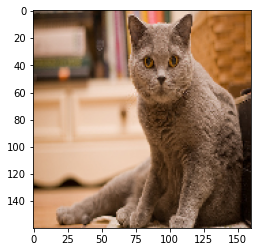

British_Shorthair


In [0]:
# data check

plt.imshow(X[999].astype('int32'))
plt.show()

print(y[999])

### Train and Test data / One-hot encoding / data normalization

In [0]:
# train and test dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [0]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5542, 160, 160, 3), (1848, 160, 160, 3), (5542,), (1848,))

In [0]:
# one-hot encoding
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# label encoding
label_encoder = LabelEncoder()
y_train_label = label_encoder.fit_transform(y_train)
y_test_label = label_encoder.fit_transform(y_test)

# onehot encoding
one_hot_encoder = OneHotEncoder(sparse=False)
y_train_label = y_train_label.reshape(len(y_train_label), 1)
y_test_label = y_test_label.reshape(len(y_test_label), 1)
y_train_onehot = one_hot_encoder.fit_transform(y_train_label)
y_test_onehot = one_hot_encoder.fit_transform(y_test_label)

In [0]:
y_train_onehot.shape

(5542, 37)

In [0]:
X_train /= 255
X_test /= 255

In [0]:
del X, y, y_train_label, y_test_label # memory management

### Modeling

In [0]:
num_classes = 37
batch_size = 10

In [0]:
input_img = layers.Input(shape=(160, 160, 3))
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPool2D((2, 2), padding='same')(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPool2D((2, 2), padding='same')(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPool2D((2, 2), padding='same')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPool2D((2, 2), padding='same', name='encoder')(x)

x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(encoded)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

autoencoder.fit(X_train, X_train, epochs=10, batch_size=batch_size, callbacks=None)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 160, 160, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 80, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 256)       295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 40, 40, 256)       590080

In [0]:
autoencoder.save('autoencoder4.h5')

### Image Search

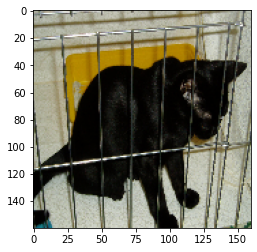

In [0]:
encoder = models.Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoder').output)
idx = 123
query = X_train[idx]
plt.imshow(query.reshape(160, 160, 3))

In [0]:
codes = encoder.predict(X_test)
query_code = encoder.predict(query.reshape(1, 160, 160, 3))

In [0]:
from sklearn.neighbors import NearestNeighbors
n_neigh = 5

codes = codes.reshape(-1, 10*10*512)
print('codes.shape: ', codes.shape)
query_code = query_code.reshape(1, 10*10*512)
print('query_code.shape: ', query_code.shape)

nbrs = NearestNeighbors(n_neighbors=n_neigh).fit(codes)

distances, indices = nbrs.kneighbors(np.array(query_code))

closest_images = X_test[indices]

closest_images = closest_images.reshape(-1, 160, 160, 3)
print('closest_image.shape: ', closest_images.shape)
print('')
# print('distance: ', distances)
print('indices: ', indices)

codes.shape:  (1848, 51200)
query_code.shape:  (1, 51200)
closest_image.shape:  (5, 160, 160, 3)

indices:  [[1802 1113 1615  938  236]]


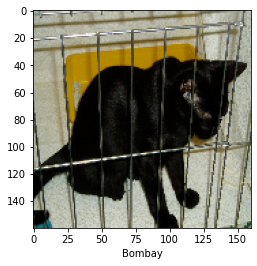

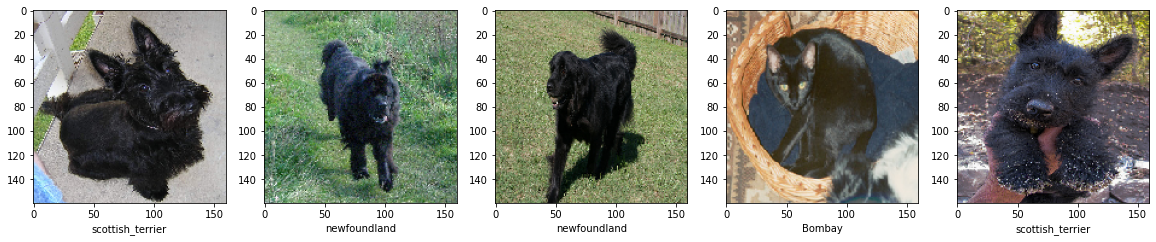

In [0]:
plt.imshow(query.reshape(160, 160, 3))
plt.xlabel(y_train[idx])

plt.figure(figsize=(20, 6))
for i in range(n_neigh):
    ax = plt.subplot(1, n_neigh, i+1)
    plt.imshow(closest_images[i].reshape(160, 160, 3))
    ax.set_xlabel(y_test[indices[0][i]])

plt.show()